<a href="https://colab.research.google.com/github/sgr1118/GD-NLP/blob/main/%5BGD_06%5D_Learn_about_bias_within_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6-8. 프로젝트 : 모든 장르 간 편향성 측정해 보기

지금까지 우리는 영화 시놉시스 코퍼스를 가지고 영화 구분과 영화 장르 간에 내재된 편향성을 측정하는 작업을 진행해 보았습니다. 어느 정도는 우리의 상식과 일치하는 편향성이 측정되었을 것입니다.

이번에는 모든 장르에 대해 영화 구분과의 편향성 정도를 측정해 보겠습니다. 대부분의 과정은 이전 스텝에서 이미 진행한 내용을 참고해서 동일하게 진행 가능할 것입니다.

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (6,402 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

# STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [ ]:
# gensim 불러오기
import os
import sys

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
#os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

In [ ]:
# konlpy 설치
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-10-05 01:22:49--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-10-05 01:22:49--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4c76c618dec0ae252e4ca1379f.dl.dropboxusercontent.com/cd/0/get/BuNfoVzHEnDb-FKb2M-YoHONxxuiET-hrKWpMQr3lTJ05oDoYktJOvAmKNUVx6hHfYp81aBBQtA4hqgnr0V_psvccyWPjIXWnlt1gUCZi3WsKQ_-1OgF6NZ7c9N9aS5EvJvvltlaeZYjRLliAnx9vrNB2PVk9053hz4W2p9RerJmX9jnOGA2UnrOMvSyv9x3CMM/file?dl=1# [following]
--2022-10-05 01:22:50--  https://uc4c76c618dec0ae252e4ca1379f.dl.dropboxusercontent.com/cd/0/get/BuNfoVzHEnDb

In [ ]:
!pip install gensim --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
# 필요한 라이브러리 불러오기
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.6.0
4.2.0
1.0.2
0.11.2


WEAT score 구현하기

In [ ]:
# 라이브러리 불러오기

import numpy as np
from numpy import dot
from numpy.linalg import norm

In [ ]:
# WEAT socre 함수 구현

def cos_sim(i, j):
  return dot(i, j.T) / (norm(i) * norm(j))

def s(w, A, B):
  c_a = cos_sim(w, A)
  c_b = cos_sim(w, B)
  mean_A = np.mean(c_a, axis=-1)
  mean_B = np.mean(c_b, axis=-1)
  return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):
  s_X = s(X, A, B)
  s_Y = s(Y, A, B)

  mean_X = np.mean(s_X)
  mean_Y = np.mean(s_Y)

  std_dev = np.std(np.concatenate([s_X, s_Y], axis = 0))

  return (mean_X - mean_Y) / std_dev

분석에 사용할 synopsis.zip 알집풀기

In [ ]:
# synopsis.zip unzip

!unzip /content/drive/MyDrive/Aiffel/GD_theory/GD6_file/synopsis.zip

Archive:  /content/drive/MyDrive/Aiffel/GD_theory/GD6_file/synopsis.zip
  inflating: synopsis.txt            
  inflating: synopsis_SF.txt         
  inflating: synopsis_action.txt     
  inflating: synopsis_adult.txt      
  inflating: synopsis_adventure.txt  
  inflating: synopsis_animation.txt  
  inflating: synopsis_art.txt        
  inflating: synopsis_comedy.txt     
  inflating: synopsis_crime.txt      
  inflating: synopsis_documentary.txt  
  inflating: synopsis_drama.txt      
  inflating: synopsis_etc.txt        
  inflating: synopsis_family.txt     
  inflating: synopsis_fantasy.txt    
  inflating: synopsis_gen.txt        
  inflating: synopsis_historical.txt  
  inflating: synopsis_horror.txt     
  inflating: synopsis_musical.txt    
  inflating: synopsis_mystery.txt    
  inflating: synopsis_romance.txt    
  inflating: synopsis_show.txt       
  inflating: synopsis_thriller.txt   
  inflating: synopsis_war.txt        
  inflating: synopsis_western.txt    


In [ ]:
# synopsis 10개 출력해보기

with open('/content/synopsis.txt', 'r') as file:
  for i in range(10):
    print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.


In [ ]:
# 명사 Tokenized 만들기
# 형태소 분석기는 Okt 사용

from konlpy.tag import Okt
okt = Okt()
tokenized = []

with open('/content/synopsis.txt', 'r') as file:
  while True:
    line = file.readline()
    if not line : break
    words = okt.pos(line, stem = True, norm = True)
    res = []
    for w in words:
      if w[1] in ['Noun']:  # "Adjective", "Verb" 등을 포함할 수도 있습니다.
        res.append(w[0]) # 명사일 때만 tokenized에 저장
    tokenized.append(res)

print(len(tokenized))

71156


# STEP 2. 추출된 결과로 embedding model 만들기

In [ ]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
# 현재 사용중인 gensim은 4.2.0버젼

model = Word2Vec(tokenized, vector_size = 100, window = 5, min_count = 3, sg =0)

워드임베딩의 most_similar() 메소드 결과 출력

In [ ]:
model.wv.most_similar(positive=['영화'])

[('작품', 0.8866482377052307),
 ('다큐멘터리', 0.8349331617355347),
 ('드라마', 0.8253748416900635),
 ('영화로', 0.8198989629745483),
 ('주제', 0.7858430743217468),
 ('형식', 0.7810127139091492),
 ('에마데딘', 0.7787023782730103),
 ('영상', 0.7741674780845642),
 ('감동', 0.7739753723144531),
 ('버자이너', 0.7719917297363281)]

In [ ]:
model.wv.most_similar(positive=['우정'])

[('우정은', 0.8482962250709534),
 ('교감', 0.8372663855552673),
 ('설킨', 0.8306812644004822),
 ('로맨스', 0.82204669713974),
 ('감정', 0.8032304644584656),
 ('갈등', 0.7903289198875427),
 ('서로', 0.7811723351478577),
 ('파국', 0.7722412943840027),
 ('화해', 0.7710098624229431),
 ('공유', 0.767482578754425)]

# STEP 3. target, attribute 단어 셋 만들기

이전 스텝에서는 TF-IDF를 사용해서 단어 셋을 만들었습니다. 이 방법으로도 어느 정도는 대표 단어를 잘 선정할 수 있습니다. 그러나 TF-IDF가 높은 단어를 골랐음에도 불구하고 중복되는 단어가 발생하는 문제가 있었습니다. 개념축을 표현하는 단어가 제대로 선정되지 않은 것은 WEAT 계산 결과에 악영향을 미칩니다.

TF-IDF를 적용했을 때의 문제점이 무엇인지 지적 가능하다면 그 문제점을 지적하고 스스로 방법을 개선하여 대표 단어 셋을 구축해 보기 바랍니다. TF-IDF 방식을 쓰더라도 중복된 단어를 잘 제거하면 여전히 유용한 방식이 될 수 있습니다.

- 영화 구분
 - synopsis_art.txt : 예술영화
 - synopsis_gen.txt : 일반영화(상업영화)
 - 그 외는 독립영화 등으로 분류됩니다.

- 장르 구분
 - synopsis_SF.txt: SF
 - synopsis_가족.txt: 가족
 - synopsis_공연.txt: 공연
 - synopsis_공포(호러).txt: 공포(호러)
 - synopsis_기타.txt: 기타
 - synopsis_다큐멘터리.txt: 다큐멘터리
 - synopsis_드라마.txt: 드라마
 - synopsis_멜로로맨스.txt: 멜로로맨스
 - synopsis_뮤지컬.txt: 뮤지컬
 - synopsis_미스터리.txt: 미스터리
 - synopsis_범죄.txt: 범죄
 - synopsis_사극.txt: 사극
 - synopsis_서부극(웨스턴).txt: 서부극(웨스턴)
 - synopsis_성인물(에로).txt: 성인물(에로)
 - synopsis_스릴러.txt: 스릴러
 - synopsis_애니메이션.txt: 애니메이션
 - synopsis_액션.txt: 액션
 - synopsis_어드벤처.txt: 어드벤처
 - synopsis_전쟁.txt: 전쟁
 - synopsis_코미디.txt: 코미디
 - synopsis_판타지.txt: 판타지

In [ ]:
# art, gen에서 TF-IDF를 사용하여 단어 셋 만들기

from sklearn.feature_extraction.text import TfidfVectorizer

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
  okt = Okt()
  result = []
  with open('/content/'+file_name, 'r') as fread:
    while True:
      line = fread.readline()
      if not line : break
      tokenlist = okt.pos(line, stem=True, norm=True)
      for word in tokenlist:
        if word[1] in ['Noun']: #, "Adjective", "Verb"]:
          result.append((word[0]))
  return ' '.join(result)

In [ ]:
art = read_token(art_txt) # 예술영화
gen = read_token(gen_txt) # 일반영화

WEAT score를 계산하기 위해 X,Y,A,B가 필요하다. 

단어 리스트를 만들때 그 주제에 맞게 적절한 단어를 뽑아내는 것이 중요하다.

예술영화를 잘 대표하는 단어란 예술영화 시놉시스에는 자주 나타나지만 그 외 다른 구분의 영화(예를 들어 일반영화) 시놉시스에는 자주 나타자니 않는 것을 고르는 것이 적당할 것이다.

즉, 코퍼스에서 자주 나타내는 단어이지만, 다른 코퍼스에까지 두루 걸쳐 나오지는 않는 단어를 선정하고 싶은 것이다.

In [ ]:
# TF-IDF

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [ ]:
# 단어장 내용 임의 확인

print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# 벡터화 정렬

m1 = X[0].tocoo() # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다.
m2 = X[1].tocoo() # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다.

w1 = [[i,j] for i,j in zip(m1.col, m1.data)]
w2 = [[i,j] for i,j in zip(m2.col, m2.data)]

w1.sort(key = lambda x : x[1], reverse = True) # art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다.
w2.sort(key = lambda x : x[1], reverse = True) # gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다

In [ ]:
# 영화를 대표하는 단어들 추출

print('예술영화를 대표하는 단어들:')
for i in range(30):
  print(vectorizer.get_feature_names()[w1[i][0]], end = ', ')

print('\n') # 줄 나누기

print('일반영화를 대표하는 단어들:')
for i in range(30):
  print(vectorizer.get_feature_names()[w2[i][0]], end = ', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 

대표하는 단어에서 중복되는 단어가 많기 때문에 중복 단어를 제거해주도록한다.

In [ ]:
n = 15

w1_, w2_ = [], [] # 각각 빈 리스트 만들어주기

for i in range(100):
  w1_.append(vectorizer.get_feature_names()[w1[i][0]])
  w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
  if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
  if len(target_art) == n : break

for i in range(100):
  if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
  if len(target_gen) == n : break

In [ ]:
print(target_art)
print(target_gen)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [ ]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [ ]:
genre = []
for file_name in genre_txt:
  genre.append(read_token(file_name))

In [ ]:
# 장르 len 확인

print(len(genre))

21


In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [ ]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i,j] for i,j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
  w[i].sort(key = lambda x : x[1], reverse = True)
attributes = []
for i in range(len(w)):
  print(genre_name[i], end = ': ')
  attr = []
  j = 0
  while (len(attr) < 15):
    if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
      attr.append(vectorizer.get_feature_names()[w[i][j][0]])
      print(vectorizer.get_feature_names()[w[i][j][0]], end = ', ')
    j += 1
  attributes.append(attr)
  print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

# STEP 4. WEAT score 계산과 시각화

영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화해 봅시다. 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성되면 좋습니다.

# 6-3. WEAT를 통한 편향성 측정

WEAT score는 다음과 같이 정의합니다.

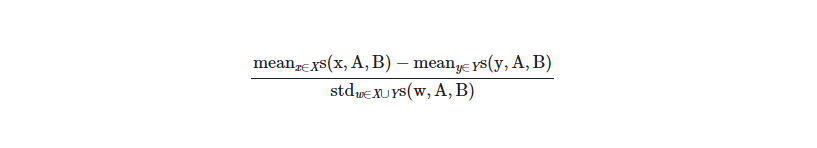

WEAT score를 계산하기 위한 식을 하나씩 살펴봅시다.

이 테스트는 두 벡터의 유사도를 측정하기 위해 cosine similarity를 이용합니다. cosine similarity는 두 벡터 사이의 cosine 값을 이용하여 두 벡터의 유사도를 측정합니다. 다시 말해, 두 벡터 i,j가 주어졌을 때, cosine similarity cos (θ)는 dot product와 magnitude를 사용하여 구할 수 있습니다.

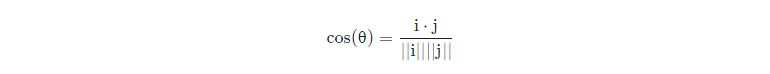

- cos(θ)=1: 두 벡터의 방향이 똑같을 때
- cos(θ)=0: 두 벡터가 직교할 때
- cos(θ)=−1: 두 벡터의 방향이 반대일 때

cosine similarity는 -1에서 1을 가질 수 있으며 두 벡터의 방향이 얼마나 유사한지를 나타내게 됩니다.

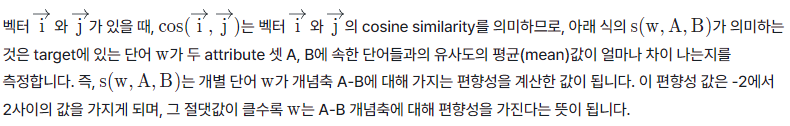

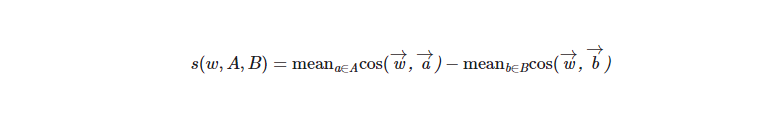

WEAT score를 다시보면 위 식의 분자 부분은 target X, Y에 속하는 각 단어 x, y들이 개념축 A-B에 대해 가지는 편향성을 r각각 평균 내서 뺀 차이입니다. 즉, X에 속하는 단어들과 Y에 속하는 단어들이 A-B 개념축에 대해 가지는 편향성의 정돠 뚜렷이 차이 날수록 이 WEAT score식의 분자값의 절댓값은 커지게 됩니다. 이 값을 X, Y에 속하는 모든 단어들이 가지는 편향성 값으 표준편차로 정규화한 값이 최종 WEAT score가 됩니다.

이제 WEAT_score를 구해봅시다.

traget_X는 art, target_Y는 gen, attribute_A는 '드라마', attribute_B는 '액션' 과 같이 정해줄 수 있습니다.

target_X 는 art, target_Y 는 gen으로 고정하고 attribute_A, attribute_B를 바꿔가면서 구해봅시다. 구한 결과를 21x21 매트릭스 형태로 표현해서 matrix 라는 변수에 담아봅시다.

for _ in range()에서 언더스코어의 의미

[파이썬 언더스코어](https://mingrammer.com/underscore-in-python/)

1. 인터프리터에서 사용되는 경우
2. 값을 무시하고 싶은 경우
3. 특별한 의미의 네이밍을 하는 경우
4. 국제화(i18n)/지역화(l10n) 함수로 사용되는 경우
5. 숫자 리터럴값의 자릿수 구분을 위한 구분자로써 사용할 때


In [ ]:
# matrix 변수 만들기

matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [ ]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [ ]:
import pandas as pd

In [ ]:
cols = []
for i in range(len(genre_name)-1):
  for j in range(i+1, len(genre_name)):
    if matrix[i][j] > 0.8 or matrix[i][j] < -0.8:
      result = [genre_name[i], genre_name[j], matrix[i][j]]
      cols.append(result)

In [ ]:
# 결과 데이터 프레임 만들기
df = pd.DataFrame(columns = ['genre_name_i', 'genre_name_j', 'WEAT_score'], data = cols)
df

,genre_name_i,genre_name_j,WEAT_score
0,SF,멜로로맨스,-0.806936
1,SF,사극,-0.851839
2,가족,다큐멘터리,0.837953
3,가족,애니메이션,0.868492
4,공연,기타,0.871263
5,공연,다큐멘터리,0.903554
6,공연,뮤지컬,0.825790
7,공연,애니메이션,0.886093
8,기타,드라마,-0.876456
9,기타,멜로로맨스,-0.887324


In [ ]:
df_desc = df.sort_values(by = 'WEAT_score', ascending=False)
df_desc

,genre_name_i,genre_name_j,WEAT_score
29,미스터리,범죄,1.004644
32,사극,전쟁,0.931681
27,멜로로맨스,코미디,0.924999
5,공연,다큐멘터리,0.903554
20,드라마,애니메이션,0.900730
7,공연,애니메이션,0.886093
25,멜로로맨스,애니메이션,0.882854
24,멜로로맨스,성인물(에로),0.877057
4,공연,기타,0.871263
3,가족,애니메이션,0.868492


# WEAT score가 0.8 이상, -0.8 이하의 경우만 해석해 보면 아래와 같습니다.

- 예술영화와 일반영화, 그리고 드라마와 멜로로맨스의 WEAT score의 의미를 해석해보면 예술영화는 멜로로맨스, 일반영화는 드라마와 가깝다고 볼 수 있습니다. 부호가 마이너스이므로 사람의 편향과 반대라는 것을 알 수 있습니다.

- 예술영화와 일반영화, 그리고 멜로로맨스와 코미디의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 코미디는 일반 영화와 가깝다고 볼 수 있습니다.

- 예술영화와 일반영화, 그리고 멜로로맨스와 전쟁의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 전쟁은 일반 영화와 가깝다고 볼 수 있습니다.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


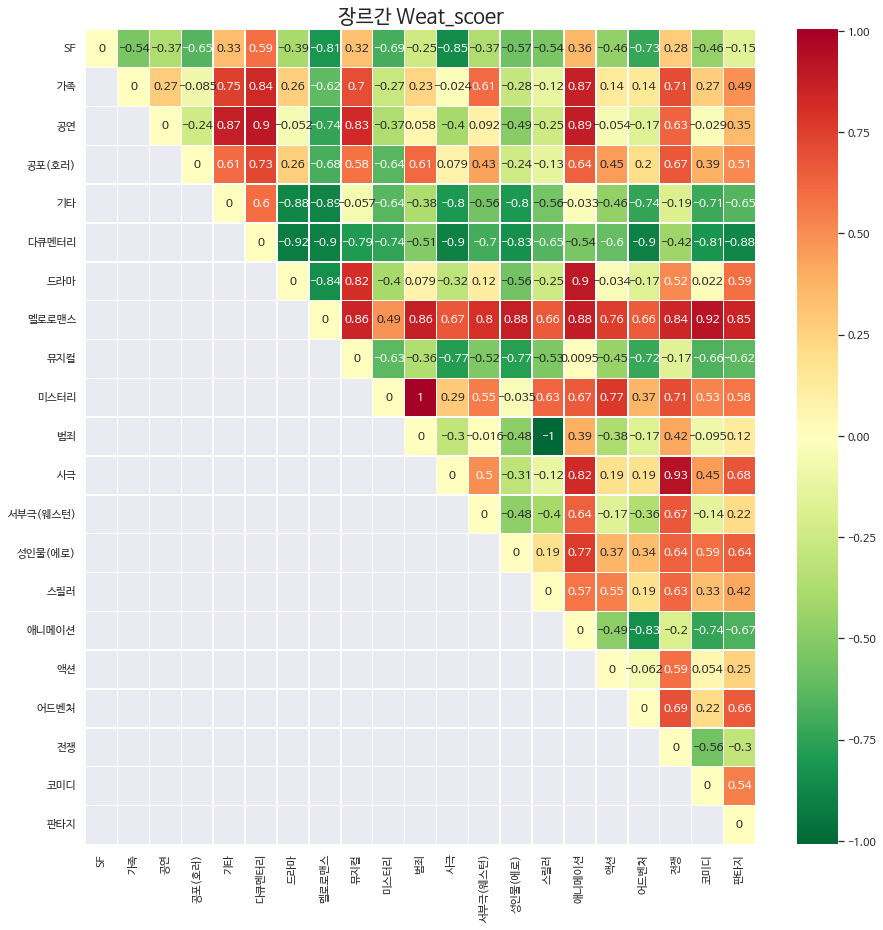

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc

# 폰트 불러오기
rc('font', family='NanumGothic')
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumBarunGothic')

# heatmap size 
f, ax = plt.subplots(figsize=(15, 15))

# 제목지정
plt.title('장르간 Weat_scoer', size = 20)

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

# 삼각형 모양으로 출력
mask = np.zeros_like(matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask = mask == False

# heatmap 제작
ax = sns.heatmap(matrix, xticklabels = genre_name, yticklabels = genre_name, mask = mask, linewidths = 0.5, annot=True, cmap='RdYlGn_r')
ax

# 회고

1. 이번 프로젝트에서 어려웠던 점
 
 (1) 

 (2) 

2. 프로젝트를 진행하면서 알게된 부분 또는 아직 이해하지 못한 부분

(1) 

- 







참조

(1) []()

(2) 

